In [1]:
import os
from dotenv import load_dotenv
load_dotenv()
import numpy as np
import pure_cv as vc
from haskellian import iter as I
import scoresheet_models as sm

### 1. Identify grid corners
- Fix `s` and `t` so that next steps are easier

**Note: the model shall only include the grid of moves, not extra rows or cols**

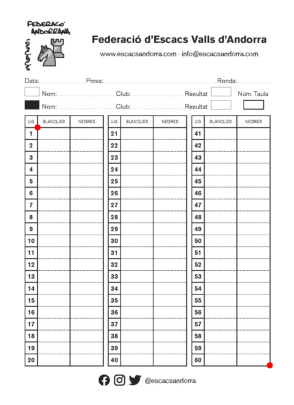

In [2]:
img = vc.imread('imgs/model.jpg')
h, w = img.shape[:2]

S = np.array([0.845, 0.618])
T = np.array([0.1, 0.305])

sheet_w = w * S[0]
sheet_h = h * S[1]

tl = T*[w, h]
br = (S+T)*[w, h]

vc.show(vc.draw.vertices(img, [tl, br], radius=10))

### 2. Find box size
- Relative box width
- Number of rows (of boxes, not grid lines)
- The image will display all points in the first block. They should match exactly only by setting `BOX_WIDTH` and `NUM_ROWS`

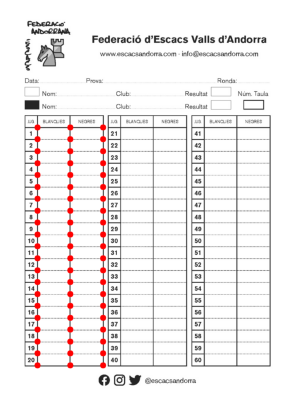

In [3]:
BOX_WIDTH = 0.141
NUM_ROWS = 20

def abs_box(box_w, num_rows):
  abs_box_w = box_w * sheet_w
  abs_box_h = sheet_h / num_rows
  return abs_box_w, abs_box_h

def block_points(top_left, box_w = BOX_WIDTH, num_rows = NUM_ROWS):
  abs_box_w, abs_box_h = abs_box(box_w, num_rows)
  first_col_lefts = [top_left + [0, abs_box_h*i] for i in range(NUM_ROWS+1)]
  first_col_rights = [top_left + [abs_box_w, abs_box_h*i] for i in range(NUM_ROWS+1)]
  second_col_rights = [top_left + [2*abs_box_w, abs_box_h*i] for i in range(NUM_ROWS+1)]
  return first_col_lefts + first_col_rights + second_col_rights

first_block_points = block_points(tl)
vc.show(vc.draw.vertices(img, first_block_points))

### 3. Find inter-block space (if applicable)
The image shows the left points of the second block numbers. They should match exactly

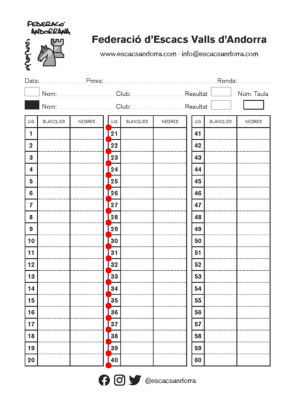

In [4]:
SPACE_W: float | None = 0.024

abs_box_w, abs_box_h = abs_box(BOX_WIDTH, NUM_ROWS)

def abs_space(space_w = SPACE_W):
  return (space_w or 0) * sheet_w
abs_space_w = abs_space()
second_block_tl = tl + [2*abs_box_w + abs_space_w, 0]
num_points = [second_block_tl + [0, abs_box_h*i] for i in range(NUM_ROWS+1)]
vc.show(vc.draw.vertices(img, num_points))

### 4. Find number box width

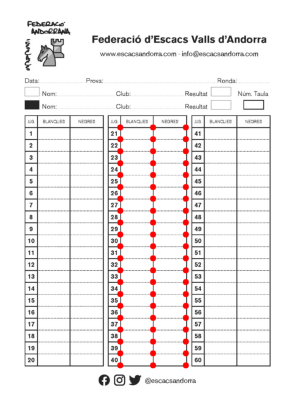

In [5]:
NUM_W: float = 0.05
abs_num_w = NUM_W * sheet_w

second_block_points = block_points(second_block_tl + [abs_num_w, 0])
vc.show(vc.draw.vertices(img, second_block_points))

### 5. Number of blocks and final adjustments

In [6]:
print('Current parameters:')
print(f'  - Box Width: {BOX_WIDTH}')
print(f'  - Space Width: {SPACE_W}')
print(f'  - Number Width: {NUM_W}')

Current parameters:
  - Box Width: 0.141
  - Space Width: 0.024
  - Number Width: 0.05


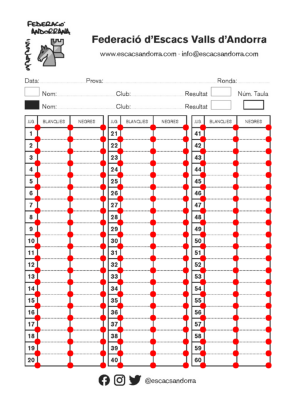

In [7]:
NUM_BLOCKS = 3
FINAL_BOX_WIDTH = BOX_WIDTH
FINAL_SPACE_W = SPACE_W
FINAL_NUM_W = NUM_W

abs_box_w, abs_box_h = abs_box(FINAL_BOX_WIDTH, NUM_ROWS)
abs_space_w = abs_space(FINAL_SPACE_W)

block_tls = [tl + [i*(2*abs_box_w + abs_space_w + abs_num_w), 0] for i in range(NUM_BLOCKS)]
all_points = I.flatten(block_points(block_tl, FINAL_BOX_WIDTH, NUM_ROWS) for block_tl in block_tls).sync()

vc.show(vc.draw.vertices(img, all_points))

### 6. Result

Model: boxWidth=0.141 rows=20 columns=[None, 0.024, 0.05, None, 0.024, 0.05, None]


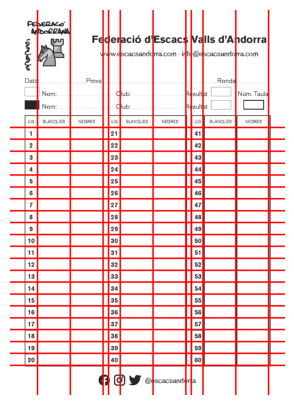

In [8]:
columns = [None]
for i in range(NUM_BLOCKS-1):
  if SPACE_W is not None:
    columns.append(SPACE_W)
  columns.extend([NUM_W, None])

model = sm.Model(boxWidth=BOX_WIDTH, rows=NUM_ROWS, columns=columns)
print('Model:', model)
vc.show(sm.draw(img, model, s=S, t=T))

### 7. Upload to CDN

In [9]:
modelId = input('Model ID: ')
await sm.save_model(modelId, model, conn_str=os.environ['BLOB_CONN_STR'])
print('Model saved! Verifying...')
fetched_model = await sm.fetch_model(modelId)
print('Fetched model:', fetched_model)

Model saved! Verifying...
Fetched model: Right(value=Model(boxWidth=0.141, rows=20, columns=[None, 0.024, 0.05, None, 0.024, 0.05, None]), tag='right')


### 8. Visualize Extracted Boxes

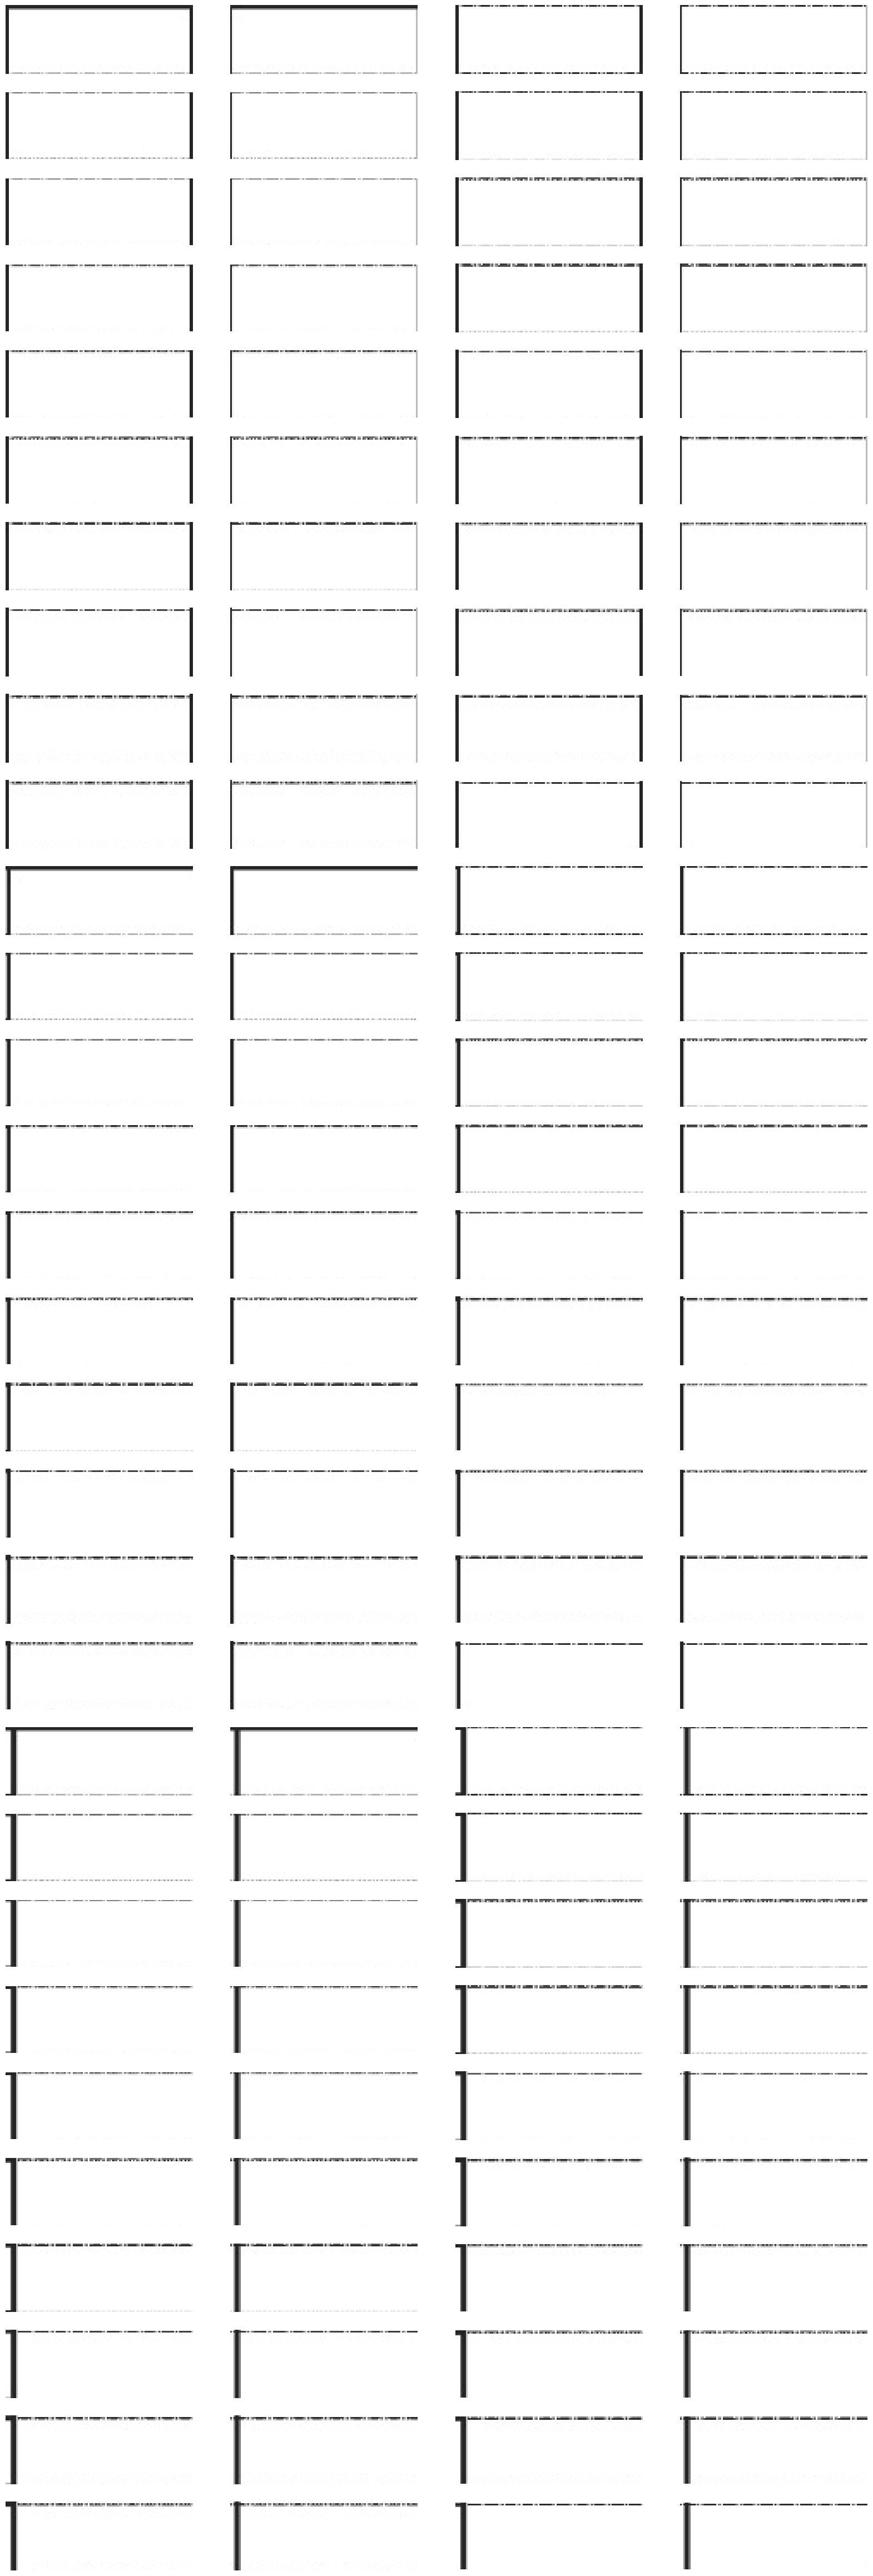

In [10]:
boxes = sm.extract_boxes(model, img, size=S, tl=T, pads=sm.Pads(l=0, r=0, t=0, b=0))
vc.show(*boxes, ncols=4, height=2)